First, a bit of a hack in case your IDE wants to run the notebook from `/guides/` and not the project root folder `/ma2`. We need the working directory to be `/ma2` for local imports to work. Why? Well, the 'src' folder is in the project root, and we need to import the modules from there. Without this hack, the imports will fail.

In [1]:
import os
from pathlib import Path

# Ensure the working directory is set to the "ma1" folder.
while Path.cwd().name != "ma2" and "ma2" in str(Path.cwd()): 
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: /Users/nicolai/Desktop/cbs/aiml25/ma2


# Bag of Words Model

___


- Bag of Words (BoW) is a fundamental text representation technique in Natural Language Processing (NLP) that transforms text into numerical features by counting word occurrences while disregarding grammar and word order. This simplistic yet powerful approach forms the foundation for many classical NLP models and serves as a stepping stone to more sophisticated text analysis methods.

- The concept of BoW was formalized in early information retrieval systems and gained prominence with the Vector Space Model ([Salton et al., 1975](https://dl.acm.org/doi/10.1145/361219.361220)), which represents documents as vectors in a high-dimensional space where each dimension corresponds to a distinct term in the vocabulary. This representation enables mathematical operations on text data, facilitating document comparison through similarity metrics like cosine similarity.

- Term Frequency-Inverse Document Frequency (TF-IDF) ([Sparck Jones, 1972](https://www.doi.org/10.1108/eb026562)) enhanced the basic BoW model by *weighting terms based on their frequency in a document relative to their occurrence across a corpus*. This addressed the limitation of treating all terms equally and has become a standard weighting scheme in information retrieval and text classification tasks.

- The BoW approach is still widely used in industry despite its simplicity. BoW-based models demonstrate surprising effectiveness for tasks like sentiment analysis, spam detection, and document categorization. Since the beginning of the deep learning era, BoW is often used as a baseline for comparing the performance of more complex models. Generally speaking, simpler is bettet!

- BoW has notable limitations: it loses contextual information, struggles with synonyms and polysemy, and creates sparse high-dimensional vectors. Modern NLP has largely transitioned to distributed word representations like **Word2Vec** ([Mikolov et al., 2013](https://arxiv.org/abs/1301.3781)) and contextualized embeddings from transformer-based models, which capture semantic relationships and contextual nuances that BoW approaches fundamentally cannot represent.

***

**In this notebook, we will** 

1. Explore how to build a BoW model from scratch using Python, as a motivating example. This way we can see the simple steps involved in building BoW models

2. **Build a BoW model with scikit-learn**: This is the common way to build BoW models. This section is meant to provide inspiration for the BoW section of the assignment. Here we work with a subset of the [AG News](https://huggingface.co/datasets/fancyzhx/ag_news) dataset, which you will also use for the assignment.


***

<div style="padding-left: 10px; padding-right: 10px; padding-top: 10px; padding-bottom: 30px, align: justify">
<p align="center">
<img src="../media/bow_slp1.png" alt="Transformer Architecture" width="800"/><br>
Image from Speech and Language Processing. Daniel Jurafsky & James H. Martin.<br> Copyright © 2024. All
rights reserved. Draft of January 12, 2025.
</p>
</div>


# 1. An introduction to bag-of-words models

* A bag-of-words model is a type of vector representation for text data that describes the occurrence of words within a document. We transform each document into a vector of word counts or frequencies. This vectorization enables standard machine learning methods.<br><br>

---

Any text (or document) can be transformed into an unordered set of words with their position ignored, keeping only their frequency in the document. In the example in the figure, instead of representing the word order in all the phrases like “<i>I love this movie</i>” and “<i>I would recommend it</i>”, we simply note that the word I occurred 5 times in the entire excerpt, the word it 6 times, the words love, recommend, and movie once, and so on. In other words, no pun intended, the position of the words is ignored (the bag-of-words assumption) and we make use of the *frequency* of each word.


In this section, we will build a bag-of-words model from scratch. Let's assume we have the same text as in the image above:


In [2]:
document = (
    "I love this movie! It's sweet, but with satirical humor. " +
    "The dialogue is great and the adventure scenes are fun... " +
    "It manages to be whimsical and romantic while laughing at the conventions of the fairy tale genre. " +
    "I would recommend it to just about anyone. I've seen it several times, and I'm always happy to see it again whenever I have a friend who hasn't seen it yet!"
)
document

"I love this movie! It's sweet, but with satirical humor. The dialogue is great and the adventure scenes are fun... It manages to be whimsical and romantic while laughing at the conventions of the fairy tale genre. I would recommend it to just about anyone. I've seen it several times, and I'm always happy to see it again whenever I have a friend who hasn't seen it yet!"

We can count the frequency of each word in the text. 

In [3]:
# split the document into words
words = document.split() # split the document into words by whitespace

# create a dictionary to store the frequency of each word
word_freq = {}
for word in words:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1

print(word_freq)

{'I': 3, 'love': 1, 'this': 1, 'movie!': 1, "It's": 1, 'sweet,': 1, 'but': 1, 'with': 1, 'satirical': 1, 'humor.': 1, 'The': 1, 'dialogue': 1, 'is': 1, 'great': 1, 'and': 3, 'the': 3, 'adventure': 1, 'scenes': 1, 'are': 1, 'fun...': 1, 'It': 1, 'manages': 1, 'to': 3, 'be': 1, 'whimsical': 1, 'romantic': 1, 'while': 1, 'laughing': 1, 'at': 1, 'conventions': 1, 'of': 1, 'fairy': 1, 'tale': 1, 'genre.': 1, 'would': 1, 'recommend': 1, 'it': 4, 'just': 1, 'about': 1, 'anyone.': 1, "I've": 1, 'seen': 2, 'several': 1, 'times,': 1, "I'm": 1, 'always': 1, 'happy': 1, 'see': 1, 'again': 1, 'whenever': 1, 'have': 1, 'a': 1, 'friend': 1, 'who': 1, "hasn't": 1, 'yet!': 1}




We will typically have more than one documents and we can build a BoW for any collection of texts. A set of documents is typically referred to as a corpus in NLP. Here we have a corpus of 8 sentences.

In [4]:
corpus = [
    "Natural Language Processing (NLP) is a fascinating field of study, which involves the interaction between computers and humans using natural language.",
    "The goal of NLP is to enable computers to understand, interpret, and generate human language in a way that is both meaningful and useful.",
    "There are many challenges in NLP, such as dealing with the ambiguity and variability of natural language.",
    "Techniques in NLP include tokenization, stemming, lemmatization, and part-of-speech tagging, among others.",
    "Applications of NLP are vast and include machine translation, sentiment analysis, and speech recognition.",
    "In recent years, deep learning has revolutionized NLP, leading to significant improvements in tasks like language modeling and text generation.",
    "Despite these advancements, there are still many open problems in NLP, such as understanding context and handling low-resource languages.",
    "Researchers in NLP are continually developing new methods and models to address these challenges and improve the performance of NLP systems."
]

In traditonal NLP - meaning the pre-transformer era - the preprocessing steps for text data were crucial. Transforming text data into a format that can be used by machine learning models is a non-trivial task. In the following, we will perform the following preprocessing steps:

- Lowercase all text
- Remove punctuation, and
- Separate words using whitespace.

In [5]:
def preprocess_text(text):


    # 1. Convert the text to lowercase
    text = text.lower()

    # 2. Remove punctuation by building a new string without those characters
    # Define punctuation characters explicitly (since we are not using any libraries)
    punctuation_chars = ".,!?;:'\"()"
    text = ''.join(char for char in text if char not in punctuation_chars)

    # 3. Tokenize by splitting on whitespace
    tokens = text.split()

    return tokens

# Process the document and print results
tokens = preprocess_text(document)
print(tokens)


['i', 'love', 'this', 'movie', 'its', 'sweet', 'but', 'with', 'satirical', 'humor', 'the', 'dialogue', 'is', 'great', 'and', 'the', 'adventure', 'scenes', 'are', 'fun', 'it', 'manages', 'to', 'be', 'whimsical', 'and', 'romantic', 'while', 'laughing', 'at', 'the', 'conventions', 'of', 'the', 'fairy', 'tale', 'genre', 'i', 'would', 'recommend', 'it', 'to', 'just', 'about', 'anyone', 'ive', 'seen', 'it', 'several', 'times', 'and', 'im', 'always', 'happy', 'to', 'see', 'it', 'again', 'whenever', 'i', 'have', 'a', 'friend', 'who', 'hasnt', 'seen', 'it', 'yet']


With preprocessing done, we can now count our words again. This time, we will have a much cleaner representation of our text data, since we have removed punctuation and converted all text to lowercase. for example, the word "I" and "i" will be counted as the same word.

In [6]:
preprocessed_documents = [preprocess_text(doc) for doc in corpus]

print(f"{len(preprocessed_documents)=} | {len(corpus)=}\n")
print(preprocessed_documents)

# Create word_freq = {}
for tokens in preprocessed_documents:
    for word in tokens:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

print(f"{len(word_freq)=}\n")
print(word_freq) # a dictionary to store the frequency of each word in the corpus


len(preprocessed_documents)=8 | len(corpus)=8

[['natural', 'language', 'processing', 'nlp', 'is', 'a', 'fascinating', 'field', 'of', 'study', 'which', 'involves', 'the', 'interaction', 'between', 'computers', 'and', 'humans', 'using', 'natural', 'language'], ['the', 'goal', 'of', 'nlp', 'is', 'to', 'enable', 'computers', 'to', 'understand', 'interpret', 'and', 'generate', 'human', 'language', 'in', 'a', 'way', 'that', 'is', 'both', 'meaningful', 'and', 'useful'], ['there', 'are', 'many', 'challenges', 'in', 'nlp', 'such', 'as', 'dealing', 'with', 'the', 'ambiguity', 'and', 'variability', 'of', 'natural', 'language'], ['techniques', 'in', 'nlp', 'include', 'tokenization', 'stemming', 'lemmatization', 'and', 'part-of-speech', 'tagging', 'among', 'others'], ['applications', 'of', 'nlp', 'are', 'vast', 'and', 'include', 'machine', 'translation', 'sentiment', 'analysis', 'and', 'speech', 'recognition'], ['in', 'recent', 'years', 'deep', 'learning', 'has', 'revolutionized', 'nlp', 'leading'

But how do we go from a dictionary of word counts to a vector representation? Think of the dictionary we have as a feature space. For each document, we can represent it as a vector where each element in the vector corresponds to the count of a word in the dictionary. This is the bag-of-words model.

To make this more concrete, we need to build a document term matrix: a matrix where each row corresponds to a document and each column corresponds to a word in the dictionary. The value in each cell is the count of the word in the document.

In [7]:
def build_document_term_matrix(preprocessed_documents):
    """
    Builds a Bag-of-Words document-term matrix.
    Returns:
    - document_term_matrix (list of lists): BoW representation of documents
    - vocab (list): Sorted vocabulary of unique words
    - word_to_index (dict): Mapping of word → index in vocabulary
    """
    # 1. Extract unique vocabulary from the dataset and sort it
    vocab = sorted(set(word for doc in preprocessed_documents for word in doc))

    # 2. Create a word-to-index mapping
    word_to_index = {word: idx for idx, word in enumerate(vocab)}

    print(word_to_index)

    # 3. Convert each document into a vector
    document_term_matrix = []
    
    for tokens in preprocessed_documents:
        doc_vector = [0] * len(vocab)  # Initialize a vector of zeros
        for token in tokens:
            if token in word_to_index:
                doc_vector[word_to_index[token]] += 1  # Increment word count
        document_term_matrix.append(doc_vector)

    print(f"\nVocabulary Size: {len(vocab)} | Number of Documents: {len(document_term_matrix)}\n")
    # Print vectors for first two sentences 
    for i, vector in enumerate(document_term_matrix[:2]):
        print(f"Document {i} vector:\n{vector}\n")
        print(f"Document {i} text:\n{preprocessed_documents[i]}\n\n{'#'*50}\n")

    # Optionally, we can inspect the shape of our document-term matrix
    print(f"Number of documents: {len(document_term_matrix)}")
    print(f"Vocabulary size: {len(vocab)}")

    return document_term_matrix, vocab, word_to_index

document_term_matrix, vocab, word_to_index = build_document_term_matrix(preprocessed_documents)

{'a': 0, 'address': 1, 'advancements': 2, 'ambiguity': 3, 'among': 4, 'analysis': 5, 'and': 6, 'applications': 7, 'are': 8, 'as': 9, 'between': 10, 'both': 11, 'challenges': 12, 'computers': 13, 'context': 14, 'continually': 15, 'dealing': 16, 'deep': 17, 'despite': 18, 'developing': 19, 'enable': 20, 'fascinating': 21, 'field': 22, 'generate': 23, 'generation': 24, 'goal': 25, 'handling': 26, 'has': 27, 'human': 28, 'humans': 29, 'improve': 30, 'improvements': 31, 'in': 32, 'include': 33, 'interaction': 34, 'interpret': 35, 'involves': 36, 'is': 37, 'language': 38, 'languages': 39, 'leading': 40, 'learning': 41, 'lemmatization': 42, 'like': 43, 'low-resource': 44, 'machine': 45, 'many': 46, 'meaningful': 47, 'methods': 48, 'modeling': 49, 'models': 50, 'natural': 51, 'new': 52, 'nlp': 53, 'of': 54, 'open': 55, 'others': 56, 'part-of-speech': 57, 'performance': 58, 'problems': 59, 'processing': 60, 'recent': 61, 'recognition': 62, 'researchers': 63, 'revolutionized': 64, 'sentiment': 6

The first step in this process is to build our vocabulary from our corpus - just as we have done before. Then, we assign a unique index to each word in the vocabulary. This index will be the column index in our document term matrix - corresponding to the word in the dictionary. 

With this in place, we can loop through our documents and count the frequency of each word in the document.  In the output above, we see that document 0 gets this vector:

```python
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
```

From this text

```python
['natural', 'language', 'processing', 'nlp', 'is', 'a', 'fascinating', 'field', 'of', 'study', 'which', 'involves', 'the', 'interaction', 'between', 'computers', 'and', 'humans', 'using', 'natural', 'language']
```

We word "a" has index 1 in our vocabulary, and it occurs once in the document, so we get a 1 in the vector at index 0. The word "and" has index 6 in our vocabulary, and it occurs once in the document, so we get a 1 in the vector at index 6. As so on.

What we have effectively done now is to transform our text data into a format that can be used by machine learning models. We have transformed our text data into a numerical representation. This is the essence of the bag-of-words model. 

When we encounter new texts, we can use the vocabulary we built and the word_to_index mapping to transform the new text into a vector representation. 

**Note**: You might also consider that we need to have a mapping for each word in the vocabulary. As there are quite a few words, the amount of memory needed to store the vocabulary can explode for large datasets. In practice, we often use a fixed vocabulary size and map all other words to an unknown token. This is a simple way to handle the issue of large vocabularies.


We can also get a feel for our vocabulary by looking at the most common words in our corpus. This can be useful for understanding the content of our corpus and for identifying words that might be irrelevant for our analysis - so-called stop words.

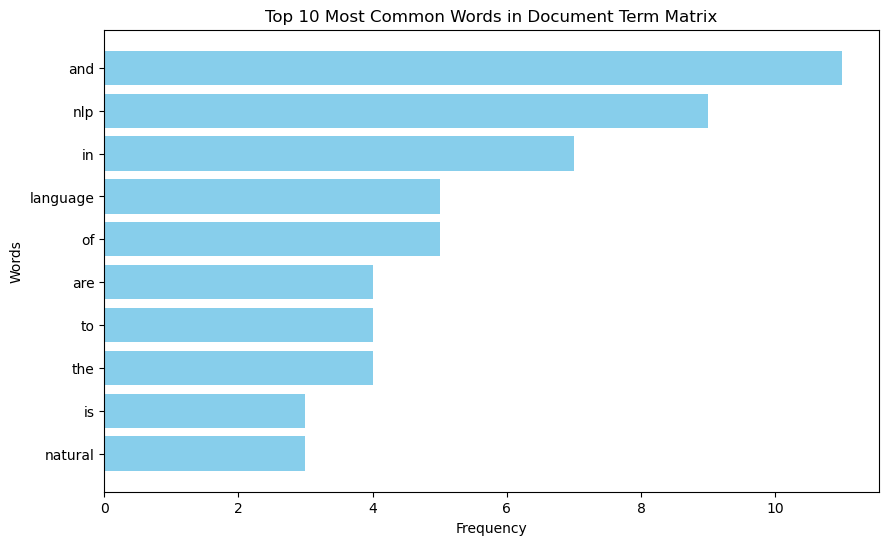

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def visualize_top_n_tokens(n, document_term_matrix):

    # Sum the occurrences of each word across all documents
    word_counts = np.sum(document_term_matrix, axis=0)

    # Get the indices of the top n most common words
    top_n_indices = np.argsort(word_counts)[-n:]

    # Get the corresponding words and their counts
    top_n_words = [vocab[i] for i in top_n_indices]
    top_n_counts = word_counts[top_n_indices]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_words, top_n_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Common Words in Document Term Matrix')
    plt.show()

visualize_top_n_tokens(10, document_term_matrix)

***

# 2. BoW using Scikit-Learn

Normally we build BoW models using Scikit-Learn's `CountVectorizer`. CountVectorizer does  preprocessing and builds word vectors, using `fit_transform`, as we will see below. Also, it provides a elaborate set of options for preprocessing. You can read more about it [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report



## 2.1. Load the data

We will be working with the AG News dataset, which is a collection of news articles from the AG's corpus of news articles on the web. The dataset has four categories: World, Sports, Business, and Science/Technology. We will use a subset of the dataset for this example.

We can load this data directly from [Hugging Face Datasets](https://huggingface.co/docs/datasets/) - The HuggingFace Hub- into a Pandas DataFrame. Pretty neat!

**Note**: This cell will download the dataset and keep it in memory. If you run this cell multiple times, it will download the dataset multiple times.

In [10]:

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}

train = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])
test = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["test"])

print(train.shape, test.shape)

(120000, 2) (7600, 2)


In [16]:

label_map = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}

def preprocess(df: pd.DataFrame, frac : float = 1e-2, label_map : dict[int, str] = label_map, seed : int = 42) -> pd.DataFrame:
    """ Preprocess the dataset 

    Operations:
    - Map the label to the corresponding category
    - Filter out the labels not in the label_map
    - Sample a fraction of the dataset (stratified by label)

    Args:
    - df (pd.DataFrame): The dataset to preprocess
    - frac (float): The fraction of the dataset to sample in each category
    - label_map (dict): A mapping of the original label to the new label
    - seed (int): The random seed for reproducibility

    Returns:
    - pd.DataFrame: The preprocessed dataset
    """

    return  (
        df
        .assign(label=lambda x: x['label'].map(label_map))
        [lambda df: df['label'].isin(label_map.values())]
        .groupby('label')[["text", "label"]]
        .apply(lambda x: x.sample(frac=frac, random_state=seed))
        .reset_index(drop=True)

    )

train_df = preprocess(train, frac=0.01)
test_df = preprocess(test, frac=0.1)

# clear up some memory by deleting the original dataframes
del train
del test

train_df.shape, test_df.shape

((1200, 2), (760, 2))

### 2.2. Split the data

The AG News dataset is already split into training and test sets. We will use Scikit-Learn's `train_test_split` to split the training set into a training and validation set. We will use the training set for training our BoW model and the validation set for evaluating the model.

In [17]:
(
    
    X_train,
    X_val,
    y_train,
    y_val

) = train_test_split(train_df["text"], train_df["label"], test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(960,) (240,) (960,) (240,)


### 2.3. Build the BoW model

All the word we did in section 1 is done by `CountVectorizer`. We will use the `fit_transform` method to build the BoW model. We will also use the `transform` method to transform the validation set into a BoW representation.

**Note**: We will __not__ fit our `CountVectorizer` on the validation set. We only fit it on the training set. This is important to avoid data leakage.

In [18]:
# countvectorizer
cv = CountVectorizer()
X_train_vectorized = cv.fit_transform(X_train)

Observe the shape of the BoW representation. The number of columns in the BoW representation corresponds to the number of unique words in the training set. This is the size of our vocabulary.

Note that the CountVectorizer has a pretty ruthless tokenizer. It will not only remove all punctuation and lowercase all text by default, as we did, it will also remove all numbers and indeed all tokens that are not pure text. We can change this behavior by passing a custom tokenizer to the CountVectorizer, if we so desire.

In [19]:
X_train_vectorized.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

### 2.4. Create a classifier

Below we create a simple classifier using Scikit-Learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). We train the classifier on the BoW representation of the training set and evaluate it on the BoW representation of the validation set.

In [20]:
lr_clf = LogisticRegression() # Note that we can set hyperparameters here

lr_clf.fit(X_train_vectorized, y_train)

LogisticRegression()

### 2.5. Get predictions

In [21]:
X_val_vectorized = cv.transform(X_val) # note that we use transform here, not fit_transform

y_pred = lr_clf.predict(X_val_vectorized)

### 2.6. Evaluate BoW model

In [22]:

print("Performance on the training set:")
print(classification_report(y_train, lr_clf.predict(X_train_vectorized), target_names=label_map.values()))

print("Performance on the validation set:")
print(classification_report(y_val, y_pred, target_names=label_map.values()))



Performance on the training set:
              precision    recall  f1-score   support

       World       1.00      1.00      1.00       238
      Sports       1.00      1.00      1.00       240
    Business       1.00      1.00      1.00       240
    Sci/Tech       1.00      1.00      1.00       242

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960

Performance on the validation set:
              precision    recall  f1-score   support

       World       0.76      0.68      0.72        62
      Sports       0.69      0.60      0.64        60
    Business       0.79      0.87      0.83        60
    Sci/Tech       0.78      0.90      0.83        58

    accuracy                           0.76       240
   macro avg       0.75      0.76      0.75       240
weighted avg       0.75      0.76      0.75       240



In [23]:
test_df_vectorized = cv.transform(test_df["text"])

print("Performance on the test set:")
print(classification_report(test_df["label"], lr_clf.predict(test_df_vectorized), target_names=label_map.values()))

Performance on the test set:
              precision    recall  f1-score   support

       World       0.74      0.72      0.73       190
      Sports       0.75      0.72      0.73       190
    Business       0.83      0.88      0.86       190
    Sci/Tech       0.79      0.79      0.79       190

    accuracy                           0.78       760
   macro avg       0.78      0.78      0.78       760
weighted avg       0.78      0.78      0.78       760

